In [12]:
import torch
from train import train_model
from dataset.utils import *
from utils import *
import numpy as np
import pickle
import time

In [2]:
then=time.time()

In [3]:
batch_size = 32
def redefine_train_parameters():
    global device, epochs, learning_rate, loss_lr, num_classes, embedding_size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 20
    learning_rate = 0.001
    loss_lr = 0.01
    num_classes = get_num_classes(train_dataset)
    embedding_size = 512

In [4]:
def train(train_dataset, test_dataset, verbose=0, pretrained=True, save_path=None):
    train_loader = load_dataset(train_dataset, batch_size, shuffle=True)
    test_loader = load_dataset(test_dataset, batch_size, shuffle=False)
    model = train_model(model_name='resnet50',
                    loss_func_name='proxy_anchor',
                    num_classes=num_classes,
                    dataloader=train_loader,
                    epochs=epochs,
                    learning_rate=learning_rate,
                    verbose=verbose,
                    save_path=save_path)
    return model, train_loader, test_loader

In [5]:
def cross_validate(dataset, k=10):
    global r1,r2,r4,r8,r16,r32
    np.random.shuffle(np.array(dataset))
    k=k
    split_len = len(dataset)//k
    max_index = split_len*k
    r1,r2,r4,r8,r16,r32= [],[],[],[],[],[]
    for fold in range(k):
        print(f'''----------
fold {fold+1}:''')
        start = split_len * fold
        train_dataset = dataset[:start] + dataset[start + split_len:max_index]
        test_dataset = dataset[start:start+split_len]
        train_loader = load_dataset(train_dataset, batch_size, shuffle=True)
        test_loader = load_dataset(test_dataset, batch_size, shuffle=False)
        model = train_model(model_name='resnet50',
                        loss_func_name='proxy_anchor',
                        num_classes=num_classes,
                        dataloader=train_loader,
                        epochs=epochs,
                        learning_rate=learning_rate,
                        verbose=0)
        recall = evaluate_cos(model, test_loader)
        r1.append(recall[0])
        r2.append(recall[1])
        r4.append(recall[2])
        r8.append(recall[3])
        r16.append(recall[4])
        r32.append(recall[5])

In [6]:
def avg_recall(name, percent=False):
    print(f'''Average Recall {name}:''')
    
    if percent:
        print(f'''R@1 : {np.mean(r1)*100}
R@2 : {np.mean(r2)*100}
R@4 : {np.mean(r4)*100}
R@8 : {np.mean(r8)*100}
R@16 : {np.mean(r16)*100}
R@32 : {np.mean(r32)*100}''')
    
    else:
        print(f'''R@1 : {np.mean(r1)}
R@2 : {np.mean(r2)}
R@4 : {np.mean(r4)}
R@8 : {np.mean(r8)}
R@16 : {np.mean(r16)}
R@32 : {np.mean(r32)}''')

In [7]:
def save_output(output, name):
    try:
        data = load_output()
    except:
        data = dict()
    data[name] = output
    with open('recall.pkl', 'wb') as file:
        pickle.dump(data, file)
        
def load_output():
    with open('recall.pkl', 'rb') as file:
        return pickle.load(file)

In [ ]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False)
test_dataset = make_dataset('LFWCustom', split='test', image_size=100, face_detection=False)
redefine_train_parameters()

In [23]:
# PA
model, train_loader, test_loader = train(train_dataset,test_dataset,save_path='./saved_models/PA.ptm')

100%|██████████| 176/176 [00:10<00:00, 17.19it/s]


Finished Training, Time: 205.9800 Best loss: 6.5239


In [24]:
name='PA'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|██████████| 176/176 [00:06<00:00, 26.59it/s]


R@1 : 78.557
R@2 : 80.914
R@4 : 82.146
R@8 : 82.949
R@16 : 83.771
R@32 : 84.574
Average Recall train_PA:
R@1 : 0.7855740046420282
R@2 : 0.809141224781289
R@4 : 0.8214604534904482
R@8 : 0.829494733083378
R@16 : 0.8377075522228173
R@32 : 0.8457418318157471


100%|██████████| 262/262 [00:10<00:00, 25.94it/s]


R@1 : 12.704
R@2 : 14.625
R@4 : 16.164
R@8 : 17.345
R@16 : 18.788
R@32 : 20.327
Average Recall test_PA:
R@1 : 0.12704282476440415
R@2 : 0.1462483597757366
R@4 : 0.16163664559227006
R@8 : 0.17344626028867946
R@16 : 0.18788023380651317
R@32 : 0.20326851962304665


In [25]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
redefine_train_parameters()
train_dataset2 = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFWCustom', split='test',  image_size=100, face_detection=False, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)

In [26]:
model, train_loader, test_loader = train(train_dataset,test_dataset, save_path='./saved_models/PA+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3).ptm')

 50%|████▉     | 175/351 [00:59<00:59,  2.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
name='PA+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3)'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|██████████| 351/351 [01:51<00:00,  3.14it/s]


R@1 : 100.000
R@2 : 100.000
R@4 : 100.000
R@8 : 100.000
R@16 : 100.000
R@32 : 100.000
Average Recall train_PA+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 1.0
R@2 : 1.0
R@4 : 1.0
R@8 : 1.0
R@16 : 1.0
R@32 : 1.0


100%|██████████| 262/262 [01:23<00:00,  3.14it/s]


R@1 : 14.577
R@2 : 15.687
R@4 : 16.665
R@8 : 17.476
R@16 : 18.048
R@32 : 19.015
Average Recall test_PA+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.14577120362638674
R@2 : 0.1568650840987713
R@4 : 0.16664678516044376
R@8 : 0.17475843969939162
R@16 : 0.1804843134915901
R@32 : 0.1901467255159251


In [8]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=3, median_unsharp_amount=2, median=True, median_size=3)
test_dataset  = make_dataset('LFWCustom', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=3, median_unsharp_amount=2, median=True, median_size=3)
redefine_train_parameters()

In [9]:
model, train_loader, test_loader = train(train_dataset,test_dataset, verbose=2)

Step: [10/176] Epoch [1/20] Loss: 0.5619 Time: 7.8357
Step: [20/176] Epoch [1/20] Loss: 1.0960 Time: 13.3299
Step: [30/176] Epoch [1/20] Loss: 1.6267 Time: 18.7544
Step: [40/176] Epoch [1/20] Loss: 2.1455 Time: 24.1611
Step: [50/176] Epoch [1/20] Loss: 2.6592 Time: 29.6181
Step: [60/176] Epoch [1/20] Loss: 3.1646 Time: 35.1157
Step: [70/176] Epoch [1/20] Loss: 3.6646 Time: 40.6076
Step: [80/176] Epoch [1/20] Loss: 4.1804 Time: 46.2654
Step: [90/176] Epoch [1/20] Loss: 4.6892 Time: 51.7105
Step: [100/176] Epoch [1/20] Loss: 5.1889 Time: 57.1554
Step: [110/176] Epoch [1/20] Loss: 5.7028 Time: 62.5677
Step: [120/176] Epoch [1/20] Loss: 6.2097 Time: 67.9880
Step: [130/176] Epoch [1/20] Loss: 6.7117 Time: 73.4204
Step: [140/176] Epoch [1/20] Loss: 7.2131 Time: 78.8528
Step: [150/176] Epoch [1/20] Loss: 7.7123 Time: 84.4706
Step: [160/176] Epoch [1/20] Loss: 8.2236 Time: 89.9067
Step: [170/176] Epoch [1/20] Loss: 8.7283 Time: 95.3424
Step: [176/176] Epoch [1/20] Loss: 9.0143 Time: 98.1047
Ep

Step: [130/176] Epoch [8/20] Loss: 5.5783 Time: 742.3088
Step: [140/176] Epoch [8/20] Loss: 6.0079 Time: 747.6966
Step: [150/176] Epoch [8/20] Loss: 6.4390 Time: 753.1076
Step: [160/176] Epoch [8/20] Loss: 6.8675 Time: 758.4710
Step: [170/176] Epoch [8/20] Loss: 7.2979 Time: 763.8510
Step: [176/176] Epoch [8/20] Loss: 7.5510 Time: 766.6527
Epoch [8/20] Loss: 7.5510 Time: 766.6532 Learning rate: 0.001
Step: [10/176] Epoch [9/20] Loss: 0.4147 Time: 772.1548
Step: [20/176] Epoch [9/20] Loss: 0.8331 Time: 777.5734
Step: [30/176] Epoch [9/20] Loss: 1.2483 Time: 782.9822
Step: [40/176] Epoch [9/20] Loss: 1.6590 Time: 788.3494
Step: [50/176] Epoch [9/20] Loss: 2.0765 Time: 793.7454
Step: [60/176] Epoch [9/20] Loss: 2.4915 Time: 799.1378
Step: [70/176] Epoch [9/20] Loss: 2.9076 Time: 804.7230
Step: [80/176] Epoch [9/20] Loss: 3.3223 Time: 810.1131
Step: [90/176] Epoch [9/20] Loss: 3.7341 Time: 815.4863
Step: [100/176] Epoch [9/20] Loss: 4.1471 Time: 820.8471
Step: [110/176] Epoch [9/20] Loss: 

Step: [20/176] Epoch [16/20] Loss: 0.7490 Time: 1441.7451
Step: [30/176] Epoch [16/20] Loss: 1.1241 Time: 1447.1160
Step: [40/176] Epoch [16/20] Loss: 1.4979 Time: 1452.4909
Step: [50/176] Epoch [16/20] Loss: 1.8721 Time: 1457.8808
Step: [60/176] Epoch [16/20] Loss: 2.2460 Time: 1463.2806
Step: [70/176] Epoch [16/20] Loss: 2.6178 Time: 1468.6818
Step: [80/176] Epoch [16/20] Loss: 2.9891 Time: 1474.2601
Step: [90/176] Epoch [16/20] Loss: 3.3603 Time: 1479.6586
Step: [100/176] Epoch [16/20] Loss: 3.7310 Time: 1485.0139
Step: [110/176] Epoch [16/20] Loss: 4.1019 Time: 1490.3908
Step: [120/176] Epoch [16/20] Loss: 4.4726 Time: 1495.7798
Step: [130/176] Epoch [16/20] Loss: 4.8435 Time: 1501.1696
Step: [140/176] Epoch [16/20] Loss: 5.2152 Time: 1506.7352
Step: [150/176] Epoch [16/20] Loss: 5.5872 Time: 1512.1363
Step: [160/176] Epoch [16/20] Loss: 5.9598 Time: 1517.5320
Step: [170/176] Epoch [16/20] Loss: 6.3320 Time: 1522.8887
Step: [176/176] Epoch [16/20] Loss: 6.5371 Time: 1525.6318
Epoch

In [10]:
name='PA+Crop(125)+AutoContrast+MedianUnsharp(size=3,amount=2)+Median(size=3)'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|██████████| 176/176 [01:31<00:00,  1.93it/s]


R@1 : 80.343
R@2 : 82.039
R@4 : 83.164
R@8 : 83.842
R@16 : 84.360
R@32 : 85.110
Average Recall train_PA+Crop(125)+AutoContrast+MedianUnsharp(size=3,amount=2)+Median(size=3):
R@1 : 0.8034279592929834
R@2 : 0.8203892162113908
R@4 : 0.8316372076414926
R@8 : 0.8384217104088556
R@16 : 0.8435993572576326
R@32 : 0.8510980182110337


100%|██████████| 262/262 [02:16<00:00,  1.92it/s]


R@1 : 15.830
R@2 : 17.714
R@4 : 19.015
R@8 : 20.386
R@16 : 21.890
R@32 : 23.548
Average Recall test_PA+Crop(125)+AutoContrast+MedianUnsharp(size=3,amount=2)+Median(size=3):
R@1 : 0.15829655254682096
R@2 : 0.177144220446141
R@4 : 0.1901467255159251
R@8 : 0.20386496480973398
R@16 : 0.21889538351425503
R@32 : 0.23547655970416317


In [8]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=7, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=5)
test_dataset  = make_dataset('LFWCustom', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=7, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=5)
redefine_train_parameters()

In [9]:
model, train_loader, test_loader = train(train_dataset,test_dataset, verbose=2)

Step: [10/176] Epoch [1/20] Loss: 0.5579 Time: 9.2088
Step: [20/176] Epoch [1/20] Loss: 1.0965 Time: 16.4271
Step: [30/176] Epoch [1/20] Loss: 1.6223 Time: 23.4110
Step: [40/176] Epoch [1/20] Loss: 2.1413 Time: 30.4282
Step: [50/176] Epoch [1/20] Loss: 2.6585 Time: 37.4653
Step: [60/176] Epoch [1/20] Loss: 3.1702 Time: 44.4760
Step: [70/176] Epoch [1/20] Loss: 3.6753 Time: 51.4951
Step: [80/176] Epoch [1/20] Loss: 4.1914 Time: 58.6749
Step: [90/176] Epoch [1/20] Loss: 4.6971 Time: 65.6805
Step: [100/176] Epoch [1/20] Loss: 5.1991 Time: 72.7060
Step: [110/176] Epoch [1/20] Loss: 5.6964 Time: 79.7364
Step: [120/176] Epoch [1/20] Loss: 6.2003 Time: 86.7628
Step: [130/176] Epoch [1/20] Loss: 6.7128 Time: 93.9867
Step: [140/176] Epoch [1/20] Loss: 7.2161 Time: 101.0089
Step: [150/176] Epoch [1/20] Loss: 7.7328 Time: 107.9982
Step: [160/176] Epoch [1/20] Loss: 8.2471 Time: 115.0569
Step: [170/176] Epoch [1/20] Loss: 8.7505 Time: 122.0321
Step: [176/176] Epoch [1/20] Loss: 9.0233 Time: 125.75

Step: [130/176] Epoch [8/20] Loss: 5.6280 Time: 952.7759
Step: [140/176] Epoch [8/20] Loss: 6.0663 Time: 959.7475
Step: [150/176] Epoch [8/20] Loss: 6.5004 Time: 966.6929
Step: [160/176] Epoch [8/20] Loss: 6.9375 Time: 973.6755
Step: [170/176] Epoch [8/20] Loss: 7.3674 Time: 980.6361
Step: [176/176] Epoch [8/20] Loss: 7.6158 Time: 984.3762
Epoch [8/20] Loss: 7.6158 Time: 984.3765 Learning rate: 0.001
Step: [10/176] Epoch [9/20] Loss: 0.4199 Time: 991.3276
Step: [20/176] Epoch [9/20] Loss: 0.8387 Time: 998.2870
Step: [30/176] Epoch [9/20] Loss: 1.2592 Time: 1005.2247
Step: [40/176] Epoch [9/20] Loss: 1.6800 Time: 1012.1780
Step: [50/176] Epoch [9/20] Loss: 2.0995 Time: 1019.3421
Step: [60/176] Epoch [9/20] Loss: 2.5160 Time: 1026.2849
Step: [70/176] Epoch [9/20] Loss: 2.9345 Time: 1033.2520
Step: [80/176] Epoch [9/20] Loss: 3.3489 Time: 1040.2447
Step: [90/176] Epoch [9/20] Loss: 3.7654 Time: 1047.1884
Step: [100/176] Epoch [9/20] Loss: 4.1792 Time: 1054.3610
Step: [110/176] Epoch [9/20

Step: [10/176] Epoch [16/20] Loss: 0.3734 Time: 1849.9903
Step: [20/176] Epoch [16/20] Loss: 0.7491 Time: 1856.9378
Step: [30/176] Epoch [16/20] Loss: 1.1238 Time: 1863.9156
Step: [40/176] Epoch [16/20] Loss: 1.4976 Time: 1871.0960
Step: [50/176] Epoch [16/20] Loss: 1.8711 Time: 1878.0646
Step: [60/176] Epoch [16/20] Loss: 2.2458 Time: 1885.0771
Step: [70/176] Epoch [16/20] Loss: 2.6193 Time: 1892.0288
Step: [80/176] Epoch [16/20] Loss: 2.9929 Time: 1899.0219
Step: [90/176] Epoch [16/20] Loss: 3.3681 Time: 1906.1949
Step: [100/176] Epoch [16/20] Loss: 3.7422 Time: 1913.1656
Step: [110/176] Epoch [16/20] Loss: 4.1171 Time: 1920.1160
Step: [120/176] Epoch [16/20] Loss: 4.4911 Time: 1927.0841
Step: [130/176] Epoch [16/20] Loss: 4.8649 Time: 1934.0613
Step: [140/176] Epoch [16/20] Loss: 5.2382 Time: 1941.2367
Step: [150/176] Epoch [16/20] Loss: 5.6136 Time: 1948.1954
Step: [160/176] Epoch [16/20] Loss: 5.9873 Time: 1955.1537
Step: [170/176] Epoch [16/20] Loss: 6.3609 Time: 1962.1095
Step: 

In [10]:
name='PA+Crop(125)+AutoContrast+MedianUnsharp(size=7,amount=1)+MedianHSV(method=sv,size=5)'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|██████████| 176/176 [01:58<00:00,  1.48it/s]


R@1 : 77.397
R@2 : 80.004
R@4 : 81.700
R@8 : 82.664
R@16 : 83.432
R@32 : 84.181
Average Recall train_PA+Crop(125)+AutoContrast+MedianUnsharp(size=7,amount=1)+MedianHSV(method=sv,size=5):
R@1 : 0.7739689341189073
R@2 : 0.8000357079093019
R@4 : 0.8169969648277093
R@8 : 0.8266381003392251
R@16 : 0.8343153008391359
R@32 : 0.8418139617925371


100%|██████████| 262/262 [02:57<00:00,  1.48it/s]


R@1 : 14.410
R@2 : 16.378
R@4 : 18.251
R@8 : 19.707
R@16 : 21.567
R@32 : 23.106
Average Recall test_PA+Crop(125)+AutoContrast+MedianUnsharp(size=7,amount=1)+MedianHSV(method=sv,size=5):
R@1 : 0.14410115710366217
R@2 : 0.1637838482643445
R@4 : 0.1825122271263271
R@8 : 0.19706548968149826
R@16 : 0.21567457950614338
R@32 : 0.23106286532267684


In [18]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFWCustom', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=True, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)

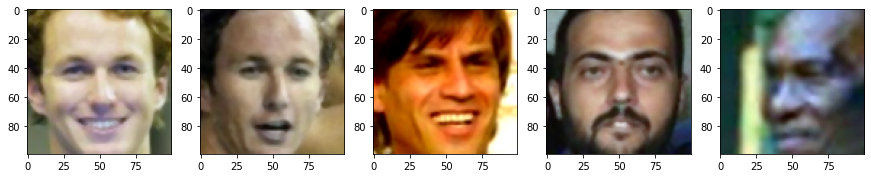

In [19]:
display_images(train_dataset,1,5)

In [20]:
model, train_loader, test_loader = train(train_dataset,test_dataset, save_path='./saved_models/PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3).ptm')

100%|██████████| 351/351 [02:01<00:00,  2.89it/s]


Finished Training, Time: 2428.8570 Best loss: 6.4304


In [ ]:
name='PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3)'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|██████████| 351/351 [01:54<00:00,  3.08it/s]


R@1 : 99.982
R@2 : 99.982
R@4 : 99.982
R@8 : 99.991
R@16 : 99.991
R@32 : 99.991
Average Recall train_PA+Crop(125)+Random+AutoContrast+MedianUnsharp(size=1,amount=1)+MedianHSV(method=sv,size=3):
R@1 : 0.9998214604534904
R@2 : 0.9998214604534904
R@4 : 0.9998214604534904
R@8 : 0.9999107302267453
R@16 : 0.9999107302267453
R@32 : 0.9999107302267453


 78%|███████▊  | 205/262 [01:05<00:18,  3.16it/s]

In [13]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=False, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=False, median_hsv_method='sv', median_hsv_size=3, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=False, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=False, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFWCustom', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_unsharp=False, median_unsharp_size=1, median_unsharp_amount=1, median_hsv=False, median_hsv_method='sv', median_hsv_size=3)

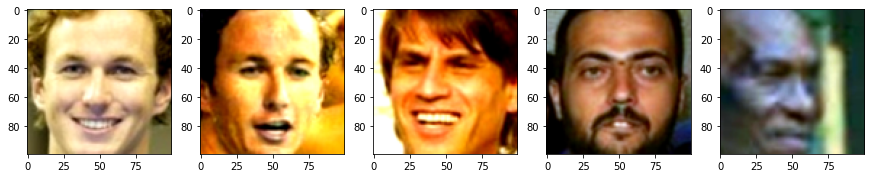

In [14]:
display_images(train_dataset,1,5)

In [16]:
model, train_loader, test_loader = train(train_dataset,test_dataset, save_path='./saved_models/PA+Crop(125)+Random+AutoContrast.ptm')

100%|██████████| 351/351 [00:25<00:00, 13.98it/s]


Finished Training, Time: 505.0316 Best loss: 6.4650


In [17]:
name='PA+Crop(125)+Random+AutoContrast'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

/workspace/Experiments/Clean/dataset/utils.py:125: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
100%|██████████| 351/351 [00:18<00:00, 19.35it/s]


R@1 : 99.920
R@2 : 99.973
R@4 : 99.973
R@8 : 99.973
R@16 : 99.982
R@32 : 99.991
Average Recall train_PA+Crop(125)+Random+AutoContrast:
R@1 : 0.999196572040707
R@2 : 0.9997321906802357
R@4 : 0.9997321906802357
R@8 : 0.9997321906802357
R@16 : 0.9998214604534904
R@32 : 0.9999107302267453


100%|██████████| 262/262 [00:11<00:00, 22.89it/s]


R@1 : 17.583
R@2 : 19.420
R@4 : 20.923
R@8 : 22.367
R@16 : 23.560
R@32 : 24.764
Average Recall test_PA+Crop(125)+Random+AutoContrast:
R@1 : 0.17583204103542885
R@2 : 0.19420255278539902
R@4 : 0.20923297148992007
R@8 : 0.22366694500775378
R@16 : 0.23559584874150066
R@32 : 0.24764404151258498


In [12]:
train_dataset = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_hsv=True, median_hsv_method='sv', median_hsv_size=3, random=True)
redefine_train_parameters()
train_dataset2 = make_dataset('LFWCustom', split='train', image_size=100, face_detection=False, crop=125, autocontrast=True, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)
train_dataset = torch.utils.data.ConcatDataset([train_dataset,train_dataset2])
test_dataset  = make_dataset('LFWCustom', split='test',  image_size=100, face_detection=False, crop=125, autocontrast=True, median_hsv=True, median_hsv_method='sv', median_hsv_size=3)

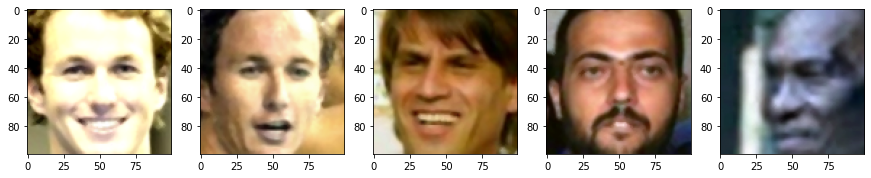

In [13]:
display_images(train_dataset,1,5)

In [14]:
model, train_loader, test_loader = train(train_dataset,test_dataset, verbose=2)

Step: [10/351] Epoch [1/20] Loss: 0.2786 Time: 2.3107
Step: [20/351] Epoch [1/20] Loss: 0.5478 Time: 4.6008
Step: [30/351] Epoch [1/20] Loss: 0.8062 Time: 6.8858
Step: [40/351] Epoch [1/20] Loss: 1.0647 Time: 9.1578
Step: [50/351] Epoch [1/20] Loss: 1.3208 Time: 11.4346
Step: [60/351] Epoch [1/20] Loss: 1.5758 Time: 13.7106
Step: [70/351] Epoch [1/20] Loss: 1.8294 Time: 15.9721
Step: [80/351] Epoch [1/20] Loss: 2.0838 Time: 18.2534
Step: [90/351] Epoch [1/20] Loss: 2.3401 Time: 20.5327
Step: [100/351] Epoch [1/20] Loss: 2.5948 Time: 22.7948
Step: [110/351] Epoch [1/20] Loss: 2.8509 Time: 25.0693
Step: [120/351] Epoch [1/20] Loss: 3.1074 Time: 27.3779
Step: [130/351] Epoch [1/20] Loss: 3.3569 Time: 29.6541
Step: [140/351] Epoch [1/20] Loss: 3.6095 Time: 32.1461
Step: [150/351] Epoch [1/20] Loss: 3.8592 Time: 34.4120
Step: [160/351] Epoch [1/20] Loss: 4.1094 Time: 36.6858
Step: [170/351] Epoch [1/20] Loss: 4.3579 Time: 38.9627
Step: [180/351] Epoch [1/20] Loss: 4.6033 Time: 41.2310
Step:

Step: [350/351] Epoch [4/20] Loss: 7.9553 Time: 317.9804
Step: [351/351] Epoch [4/20] Loss: 7.9733 Time: 318.0192
Epoch [4/20] Loss: 7.9733 Time: 318.0193 Learning rate: 0.001
Step: [10/351] Epoch [5/20] Loss: 0.2258 Time: 320.2684
Step: [20/351] Epoch [5/20] Loss: 0.4517 Time: 322.6679
Step: [30/351] Epoch [5/20] Loss: 0.6739 Time: 324.9024
Step: [40/351] Epoch [5/20] Loss: 0.8955 Time: 327.1547
Step: [50/351] Epoch [5/20] Loss: 1.1199 Time: 329.3862
Step: [60/351] Epoch [5/20] Loss: 1.3392 Time: 331.6429
Step: [70/351] Epoch [5/20] Loss: 1.5616 Time: 333.8919
Step: [80/351] Epoch [5/20] Loss: 1.7824 Time: 336.1537
Step: [90/351] Epoch [5/20] Loss: 2.0043 Time: 338.3796
Step: [100/351] Epoch [5/20] Loss: 2.2242 Time: 340.6142
Step: [110/351] Epoch [5/20] Loss: 2.4441 Time: 342.8460
Step: [120/351] Epoch [5/20] Loss: 2.6670 Time: 345.0932
Step: [130/351] Epoch [5/20] Loss: 2.8870 Time: 347.3294
Step: [140/351] Epoch [5/20] Loss: 3.1069 Time: 349.5921
Step: [150/351] Epoch [5/20] Loss: 

Step: [320/351] Epoch [8/20] Loss: 6.3685 Time: 627.6525
Step: [330/351] Epoch [8/20] Loss: 6.5647 Time: 629.8790
Step: [340/351] Epoch [8/20] Loss: 6.7615 Time: 632.1172
Step: [350/351] Epoch [8/20] Loss: 6.9595 Time: 634.3794
Step: [351/351] Epoch [8/20] Loss: 6.9756 Time: 634.4220
Epoch [8/20] Loss: 6.9756 Time: 634.4226 Learning rate: 0.001
Step: [10/351] Epoch [9/20] Loss: 0.1998 Time: 636.6711
Step: [20/351] Epoch [9/20] Loss: 0.4017 Time: 638.9336
Step: [30/351] Epoch [9/20] Loss: 0.6023 Time: 641.1782
Step: [40/351] Epoch [9/20] Loss: 0.7999 Time: 643.4618
Step: [50/351] Epoch [9/20] Loss: 0.9964 Time: 645.7028
Step: [60/351] Epoch [9/20] Loss: 1.1936 Time: 648.1135
Step: [70/351] Epoch [9/20] Loss: 1.3887 Time: 650.3592
Step: [80/351] Epoch [9/20] Loss: 1.5834 Time: 652.6090
Step: [90/351] Epoch [9/20] Loss: 1.7772 Time: 654.8476
Step: [100/351] Epoch [9/20] Loss: 1.9718 Time: 657.0999
Step: [110/351] Epoch [9/20] Loss: 2.1666 Time: 659.3403
Step: [120/351] Epoch [9/20] Loss: 

Step: [270/351] Epoch [12/20] Loss: 5.0762 Time: 932.7445
Step: [280/351] Epoch [12/20] Loss: 5.2637 Time: 934.9775
Step: [290/351] Epoch [12/20] Loss: 5.4510 Time: 937.2108
Step: [300/351] Epoch [12/20] Loss: 5.6376 Time: 939.4407
Step: [310/351] Epoch [12/20] Loss: 5.8243 Time: 941.6980
Step: [320/351] Epoch [12/20] Loss: 6.0113 Time: 943.9583
Step: [330/351] Epoch [12/20] Loss: 6.1991 Time: 946.2220
Step: [340/351] Epoch [12/20] Loss: 6.3861 Time: 948.4856
Step: [350/351] Epoch [12/20] Loss: 6.5731 Time: 950.9315
Step: [351/351] Epoch [12/20] Loss: 6.5856 Time: 950.9719
Epoch [12/20] Loss: 6.5856 Time: 950.9721 Learning rate: 0.0001
Step: [10/351] Epoch [13/20] Loss: 0.1869 Time: 953.2227
Step: [20/351] Epoch [13/20] Loss: 0.3738 Time: 955.4587
Step: [30/351] Epoch [13/20] Loss: 0.5607 Time: 957.6922
Step: [40/351] Epoch [13/20] Loss: 0.7473 Time: 959.9213
Step: [50/351] Epoch [13/20] Loss: 0.9341 Time: 962.1574
Step: [60/351] Epoch [13/20] Loss: 1.1213 Time: 964.4103
Step: [70/351]

Step: [190/351] Epoch [16/20] Loss: 3.5223 Time: 1231.7684
Step: [200/351] Epoch [16/20] Loss: 3.7075 Time: 1234.0343
Step: [210/351] Epoch [16/20] Loss: 3.8930 Time: 1236.2641
Step: [220/351] Epoch [16/20] Loss: 4.0778 Time: 1238.6943
Step: [230/351] Epoch [16/20] Loss: 4.2638 Time: 1240.9581
Step: [240/351] Epoch [16/20] Loss: 4.4487 Time: 1243.2367
Step: [250/351] Epoch [16/20] Loss: 4.6338 Time: 1245.4990
Step: [260/351] Epoch [16/20] Loss: 4.8189 Time: 1247.7424
Step: [270/351] Epoch [16/20] Loss: 5.0043 Time: 1250.0370
Step: [280/351] Epoch [16/20] Loss: 5.1895 Time: 1252.3226
Step: [290/351] Epoch [16/20] Loss: 5.3746 Time: 1254.5616
Step: [300/351] Epoch [16/20] Loss: 5.5597 Time: 1256.8296
Step: [310/351] Epoch [16/20] Loss: 5.7449 Time: 1259.1560
Step: [320/351] Epoch [16/20] Loss: 5.9302 Time: 1261.4058
Step: [330/351] Epoch [16/20] Loss: 6.1151 Time: 1263.6666
Step: [340/351] Epoch [16/20] Loss: 6.3005 Time: 1265.9228
Step: [350/351] Epoch [16/20] Loss: 6.4857 Time: 1268.19

Step: [110/351] Epoch [20/20] Loss: 2.0279 Time: 1530.0499
Step: [120/351] Epoch [20/20] Loss: 2.2120 Time: 1532.2894
Step: [130/351] Epoch [20/20] Loss: 2.3963 Time: 1534.5722
Step: [140/351] Epoch [20/20] Loss: 2.5806 Time: 1536.8113
Step: [150/351] Epoch [20/20] Loss: 2.7648 Time: 1539.0678
Step: [160/351] Epoch [20/20] Loss: 2.9489 Time: 1541.3032
Step: [170/351] Epoch [20/20] Loss: 3.1330 Time: 1543.5493
Step: [180/351] Epoch [20/20] Loss: 3.3173 Time: 1545.7790
Step: [190/351] Epoch [20/20] Loss: 3.5017 Time: 1548.0158
Step: [200/351] Epoch [20/20] Loss: 3.6859 Time: 1550.2768
Step: [210/351] Epoch [20/20] Loss: 3.8701 Time: 1552.5149
Step: [220/351] Epoch [20/20] Loss: 4.0542 Time: 1554.7358
Step: [230/351] Epoch [20/20] Loss: 4.2383 Time: 1556.9571
Step: [240/351] Epoch [20/20] Loss: 4.4223 Time: 1559.2119
Step: [250/351] Epoch [20/20] Loss: 4.6069 Time: 1561.4442
Step: [260/351] Epoch [20/20] Loss: 4.7909 Time: 1563.6778
Step: [270/351] Epoch [20/20] Loss: 4.9750 Time: 1565.92

In [15]:
name='PA+Crop(125)+Random+AutoContrast+MedianHSV(method=sv,size=3)'
save_output(evaluate_cos(model,train_loader),f'train_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'train_{name}']
avg_recall(f'train_{name}')
save_output(evaluate_cos(model,test_loader),f'test_{name}')
r1,r2,r4,r8,r16,r32=load_output()[f'test_{name}']
avg_recall(f'test_{name}')

100%|██████████| 351/351 [01:12<00:00,  4.84it/s]


R@1 : 99.804
R@2 : 99.839
R@4 : 99.920
R@8 : 99.938
R@16 : 99.938
R@32 : 99.964
Average Recall train_PA+Crop(125)+Random+AutoContrast+MedianHSV(method=sv,size=3):
R@1 : 0.9980360649883949
R@2 : 0.998393144081414
R@4 : 0.999196572040707
R@8 : 0.9993751115872166
R@16 : 0.9993751115872166
R@32 : 0.9996429209069809


100%|██████████| 262/262 [00:51<00:00,  5.08it/s]


R@1 : 16.891
R@2 : 18.907
R@4 : 20.422
R@8 : 21.687
R@16 : 22.892
R@32 : 24.013
Average Recall test_PA+Crop(125)+Random+AutoContrast+MedianHSV(method=sv,size=3):
R@1 : 0.16891327686985566
R@2 : 0.18907312417988786
R@4 : 0.2042228319217464
R@8 : 0.21686746987951808
R@16 : 0.2289156626506024
R@32 : 0.24012883216032446


In [11]:
total_time = then-time.time()
save_output(total_time, 'total_time')

In [14]:
load_output()['total_time']

-5657.035493612289

In [23]:
load_output()

{'train_PA': [0.4929476879128727,
  0.562935190144617,
  0.6120335654347437,
  0.6564899125156222,
  0.6889841099803606,
  0.719514372433494],
 'test_PA': [0.07527138255994274,
  0.09304544912322557,
  0.11034235953715854,
  0.12871287128712872,
  0.15101992126923536,
  0.17117976857926756],
 'train_PA+Unsharp': [0.7568291376539904,
  0.7818246741653276,
  0.7993215497232637,
  0.8116407784324228,
  0.8225316907695055,
  0.8332440635600785],
 'test_PA+Unsharp': [0.12072050578551831,
  0.13742097101276393,
  0.14887271859716092,
  0.16318740307765717,
  0.17607061911010377,
  0.19265179530001192],
 'train_PA+MedianUnsharp+Median': [0.7786109623281556,
  0.7996786288162828,
  0.8121763970719514,
  0.8209248348509195,
  0.8271737189787538,
  0.8336011426530977],
 'test_PA+MedianUnsharp+Median': [0.12429917690564238,
  0.13861386138613863,
  0.15137778838124777,
  0.16294882500298222,
  0.1745198616247167,
  0.1889538351425504],
 'total_time': -5657.035493612289,
 'train_PA+AutoContrast+Me